In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
# import sumo as sm
import os
from traffic_initialization import *
import sys
from bs4 import BeautifulSoup
import tqdm
import pandas as pd

# New handy interface is here!
# Check interface.py for possible parameters
from interface import Simulation
%env SUMO_HOME=/usr/share/sumo
from datetime import datetime
%load_ext autotime

import concurrent.futures
from Some_models import OptimalDist

env: SUMO_HOME=/usr/share/sumo
time: 187 ms (started: 2024-04-27 00:11:51 +03:00)


In [2]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()

def throughput(N, d0, d1, d2, d3=2, default_gap=3, N_ave=12):
    
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

time: 489 µs (started: 2024-04-27 00:11:51 +03:00)


# Evidance of effect existence

Бытовой опыт и подсказывает нам, что при соблюдении некоторой дистанции на дороге, пробки рассасываются быстрее, однако простого изменения дистанции недостаточно. Например, при изменении фиксированного на всей трассе гэпа моделирование дает тривиальный результат: чем меньше расстояние между машинами - тем больше скорость потока.

In [5]:
X = np.linspace(0, 20, 10)
Y = np.zeros((X.shape))

for i in tqdm.tqdm(range(X.shape[0])):
    Y[i], _ = throughput(N=100, d0=X[i], d1=X[i], d2=X[i], d3=X[i], default_gap=X[i], N_ave=8)

100%|██████████| 10/10 [00:00<00:00, 15.57it/s]

time: 647 ms (started: 2024-04-27 00:00:58 +03:00)


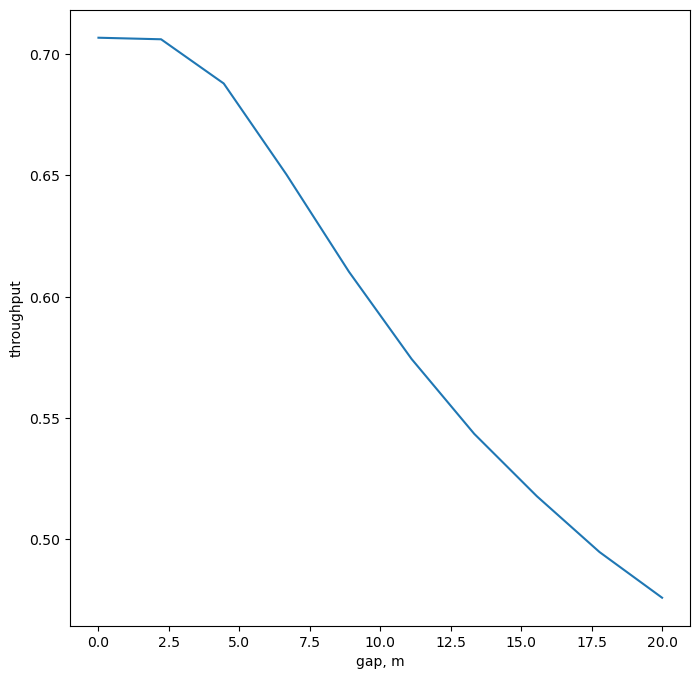

time: 107 ms (started: 2024-04-27 00:01:00 +03:00)


In [6]:
plt.subplots(figsize=(8, 8))
plt.plot(X, Y)
plt.xlabel('gap, m')
plt.ylabel('throughput')
plt.show()

Однако, если увеличить растояние на между машинами на линиях, заканчивающихся тупиком, можно получить существенный выигрыш в пропускной способности участка.

In [7]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test1', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=4)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 575.0 sec
time: 131 ms (started: 2024-04-27 00:01:03 +03:00)


In [8]:
sim = Simulation(start_road='E0', end_road='E2', N=200, sim_speed=1, default_speed=30, work_dir='./xml_data/pres_test2', net_data='test6.net.xml')
sim.set_calibrator(road='E1', lane=['0', '1'], gap=20)
sim.run()
print(f'All cars passed in {sim.get_simtime()} sec')

All cars passed in 455.0 sec
time: 94.6 ms (started: 2024-04-27 00:01:04 +03:00)


In [ ]:
X = np.linspace(0, 20, 20)
Y = np.linspace(0, 20, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=5000, d0=X[i], d1=X[i], d2=Y[j], d3=Y[j], default_gap=Y[j], N_ave=8)
np.savez('res_data/pres_graph', X=X,Y=Y, Z=Z)

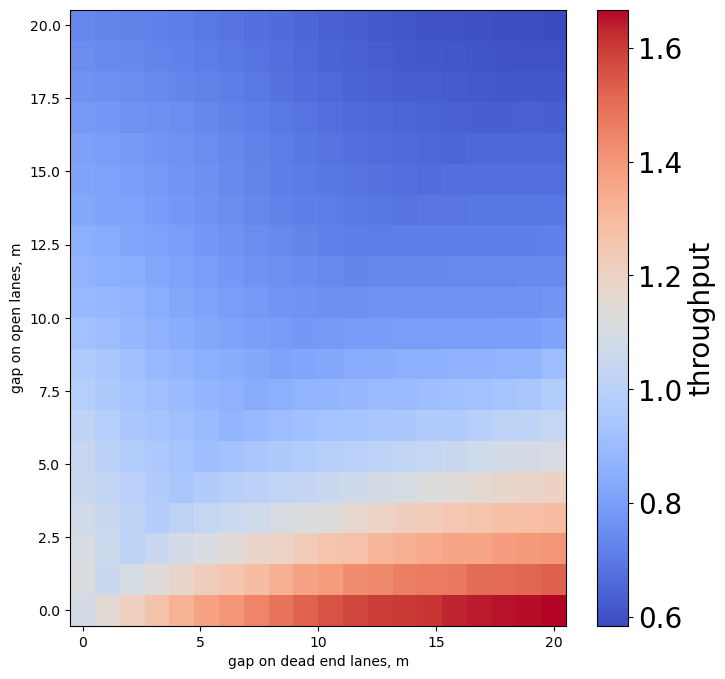

time: 81.2 ms (started: 2024-04-27 00:01:10 +03:00)


In [9]:
dict_ = np.load('res_data/pres_graph.npz')
X = dict_['X']
Y = dict_['Y']
Z = dict_['Z']

fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 8))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'gap on open lanes, m'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()
np.savez('res_data/pres_graph', X=X,Y=Y, Z=Z)

In [ ]:
X = np.linspace(0, 40, 20)
Y = np.linspace(1000, 5000, 20)
Z = np.zeros((X.shape[0], Y.shape[0]))

for i in tqdm.tqdm(range(X.shape[0])):
    for j in range(Y.shape[0]):
        Z[i, j], _ = throughput(N=Y[j], d0=X[i], d1=X[i], d2=3, d3=3, default_gap=3, N_ave=8)
np.savez('res_data/pres_graph2', X=X,Y=Y, Z=Z)

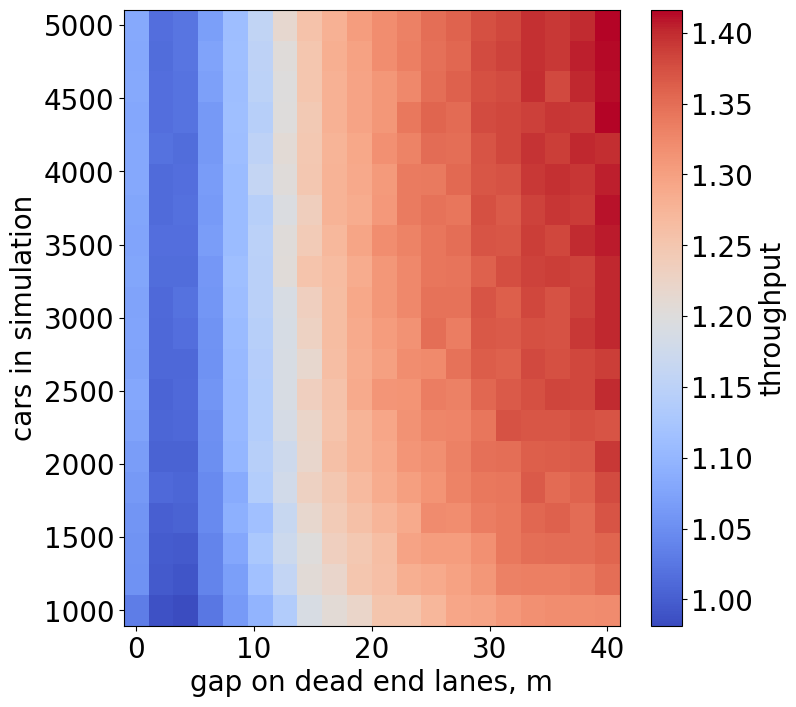

time: 79.3 ms (started: 2024-04-27 00:01:12 +03:00)


In [10]:
dict_ = np.load('res_data/pres_graph2.npz')
X = dict_['X']
Y = dict_['Y']
Z = dict_['Z']

fig, axs = plt.subplots(nrows = 1, ncols = 1,figsize = (8, 8))
plt.rcParams['font.size'] = '20'
xGrid, yGrid = np.meshgrid(X[:], Y)
xlabel = 'gap on dead end lanes, m'
ylabel = 'cars in simulation'
colorbar_label = 'throughput' 

cmap_set = 'coolwarm'
cb = axs.pcolormesh(xGrid, yGrid, np.transpose(Z[:, :]), cmap = cmap_set)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)
cb = fig.colorbar(cb, ax=axs)
cb.set_label(colorbar_label)

plt.show()

# Simple traffic without gap optimization

In [ ]:
# calculation of throughput()
N_arr=np.linspace(4000, 6000, 200)
out=np.zeros((200, 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], 2, 2, 2, default_gap=2)
    
np.savez('res_data/simple_throughput_wide', out=out, N_arr=N_arr)

<function matplotlib.pyplot.show(close=None, block=None)>

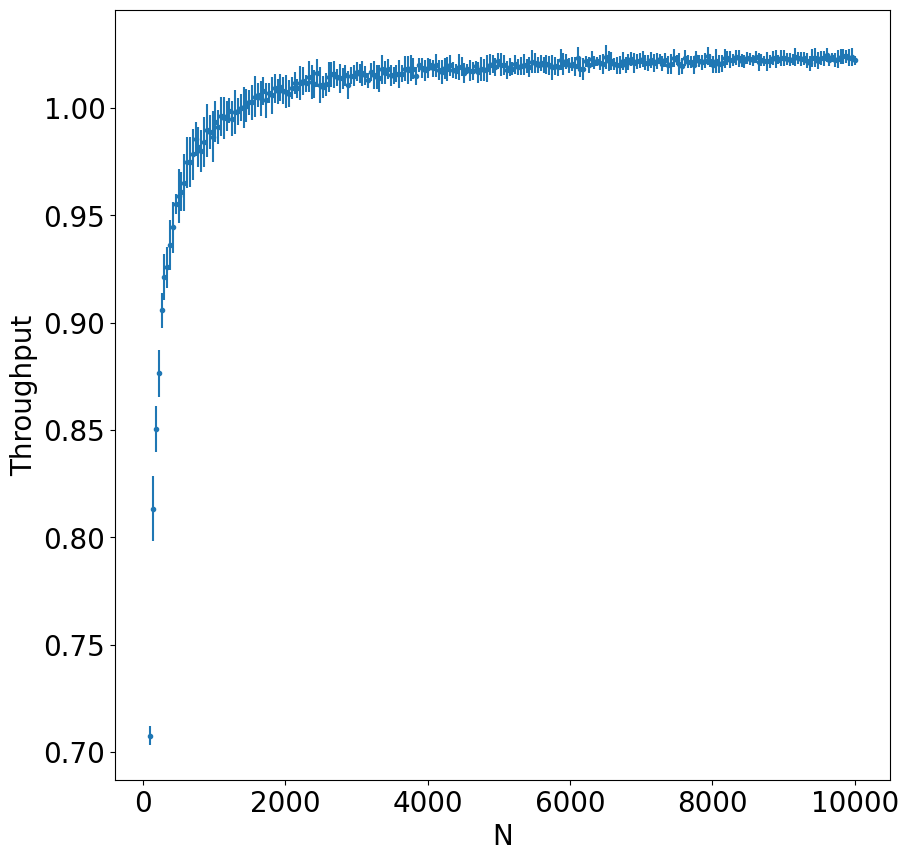

time: 80.2 ms (started: 2024-04-27 00:02:31 +03:00)


In [13]:
data = np.load('res_data/simple_throughput_wide.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:250, 0], yerr=np.asarray(data['out'][:250, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

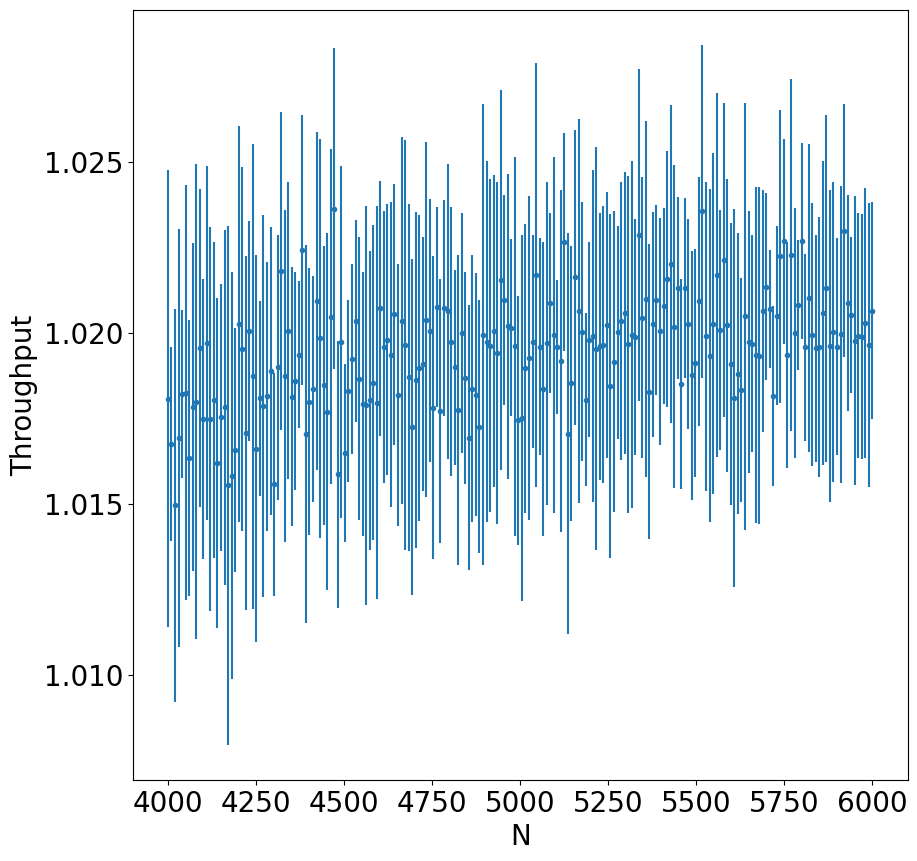

time: 80 ms (started: 2024-04-25 23:22:50 +03:00)


In [36]:
data = np.load('res_data/simple_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# Optimization with annealing

In [77]:
def single_simulation(index, seed, N, d0, d1, d2, d3=2, default_gap=3):
    sim = Simulation(start_road='E0', end_road='E2', default_gap=default_gap, N=N, work_dir=f'./xml_data/threading/thread{index}', net_data='test6.net.xml')
    sim.set_calibrator(road='E1', lane=['0'], gap=d0)
    sim.set_calibrator(road='E1', lane=['1'], gap=d1)
    sim.set_calibrator(road='E1', lane=['2'], gap=d2)
    sim.set_calibrator(road='E1', lane=['3'], gap=d3)
    sim.set_calibrator(road='E2', gap=1.5)
    sim.run(seed=seed)

    return sim.get_mean_throughput()

time: 261 µs (started: 2024-04-25 19:18:17 +03:00)


In [78]:
def throughput(N, d0, d1, d2, d3=2, default_gap=3, N_ave=12):
    
    seed_list = np.random.randint(-2**30, 2**30, N_ave)
    with concurrent.futures.ThreadPoolExecutor(max_workers=N_ave) as executor:
        futures = [executor.submit(single_simulation, index, seed, N, d0, d1, d2, d3, default_gap) 
                   for index, seed in enumerate(seed_list)]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]   
    mean = np.mean(results)
    standart_deviation = np.std(results)
    
    return mean, standart_deviation

time: 261 µs (started: 2024-04-25 19:18:18 +03:00)


In [81]:
def loss(d, N):

    mean, _ = throughput(N=N, d0=d[0], d1=d[0], d2=d[1], N_ave=12)

    filename='csv_data/test6_mean.csv'
    csv_data = pd.read_csv(filename)
    csv_data.loc[len(csv_data)] = (d[0], d[0], d[1], N, mean)
    csv_data.to_csv(filename, index=False) 
    
    return -mean

time: 385 µs (started: 2024-04-25 19:24:35 +03:00)


In [84]:
# simple optimization

N_arr = np.zeros(1)
opt_d = np.zeros((1, 2))
opt_throughput = np.zeros(1)

for n in tqdm.tqdm(range(1)):

    N = 4000 + n*150
    
    sol = sc.optimize.dual_annealing(loss, bounds=[(10, 40), (1.5, 30)], args=[N], maxiter=50, no_local_search=True)
    ans = sol.x

    opt_d[n, :] = ans
    N_arr[n] = N
    opt_throughput[n] = -sol.fun
    
    np.savez('res_data/annealing_res', opt_d=opt_d, N_arr=N_arr)


100%|██████████| 1/1 [09:11<00:00, 551.23s/it]

time: 9min 11s (started: 2024-04-25 21:25:33 +03:00)


In [118]:
# dots for graph calc

data = np.load('res_data/annealing_res.npz')

opt_d = data['opt_d']

N_arr = data['N_arr']
out=np.zeros((N_arr.shape[0], 2))

for n in tqdm.tqdm(range(N_arr.shape[0])):
    
    out[n, :] = throughput(N_arr[n], opt_d[n, 0], opt_d[n, 0], opt_d[n, 1])
    
np.savez('res_data/annealing_throughput', out=out, N_arr=N_arr)

100%|██████████| 13/13 [00:51<00:00,  3.95s/it]

time: 51.4 s (started: 2024-04-25 21:54:02 +03:00)


<function matplotlib.pyplot.show(close=None, block=None)>

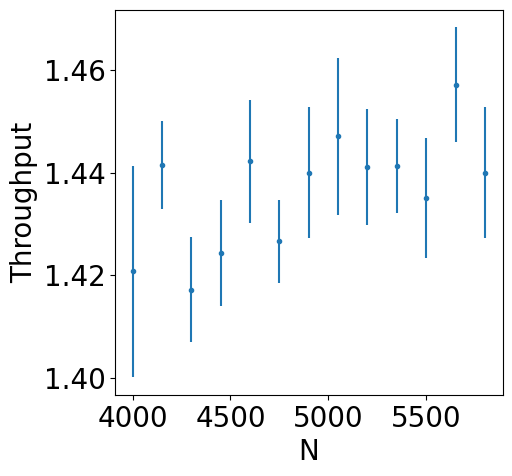

time: 54.9 ms (started: 2024-04-25 23:17:55 +03:00)


In [18]:
data=np.load('res_data/annealing_throughput.npz')

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".")

plt.rcParams['font.size'] = '20'
plt.show

# ML на основе бустинга
Тут есть два датасета:
    первый - состоит из значений troughput, посчитанных в случайных точках;
    второй - оптимизированный датасет, полученный из первого путем максимимзации значения throoughput

Далее обучаемся на каждом датасете и строим график для сравнения

In [11]:
dataName = 'csv_data/test6_without.csv'

raw_data = pd.read_csv(dataName)
print(raw_data.shape)
max_troughoutput_data = raw_data.loc[raw_data.groupby('N')['throughput'].idxmax()].reset_index(drop=True)
max_troughoutput_data.to_csv('csv_data/test6_without_cleaned.csv', index=False)
max_troughoutput_data.shape

(76373, 5)


(2001, 5)

time: 77.4 ms (started: 2024-04-27 00:13:17 +03:00)


In [16]:
obj = OptimalDist()
obj.fit_data('csv_data/test6_cleaned.csv', n_estimators=100, max_depth=3, seed=9)

MSE на обучающих данных: 18.13814470698405
MSE на тестовых данных: 160.03277563618974
time: 54 ms (started: 2024-04-27 00:13:59 +03:00)


In [8]:
# bad_data_filename = 'csv_data/test6_mean_combined.csv'
bad_data_filename = 'csv_data/test6_without.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

# good_data_filename = 'csv_data/test6_cleaned.csv'
good_data_filename = 'csv_data/test6_without_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

data_filenames = [bad_data_filename, good_data_filename]
res_filenames = [bad_res_filename, good_res_filename]

obj = OptimalDist()

for i in range(len(data_filenames)):
    obj.fit_data(data_filenames[i])
    inflow = np.arange(4000, 6001, 20)
    outflow = np.zeros((len(inflow), 2))

    for j in tqdm.tqdm(range(len(inflow))):
    # for j, n in enumerate(inflow):
        d0, d1, d2 = obj.predict(inflow[j])[0]
        outflow[j, :] = throughput(d0=d0, d1=d1, d2=d2, N=inflow[j])
    np.savez(res_filenames[i], N_arr=inflow, out=outflow)

MSE на обучающих данных: 102.79189342916679
MSE на тестовых данных: 105.16850444046578


  5%|▍         | 5/101 [00:13<04:15,  2.66s/it]malloc(): unaligned fastbin chunk detected 3
malloc(): unaligned fastbin chunk detected 3
  5%|▍         | 5/101 [00:14<04:36,  2.88s/it]

Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.
Interrupt signal received, trying to exit gracefully.


KeyboardInterrupt: 

time: 15.4 s (started: 2024-04-27 00:12:29 +03:00)


In [ ]:
bad_data = np.load(bad_res_filename)
good_data = np.load(good_res_filename)

fig, ax = plt.subplots()
ax.set_title("ML")
ax.set_xlabel("Число машин, шт")
ax.set_ylabel("Выходной поток")
ax.errorbar(good_data['N_arr'], good_data['out'][:,0], yerr=good_data['out'][:,1], fmt='.', label='хороший датасет')
ax.errorbar(bad_data['N_arr'], bad_data['out'][:,0], yerr=bad_data['out'][:,1], fmt='.', label='плохой датасет')
# ax.plot(good_data['N_arr'], good_data['out'][:,0], label='хороший датасет')
# ax.plot(bad_data['N_arr'], bad_data['out'][:,0], label='плохой датасет')
ax.grid()
ax.legend()
plt.show()

# DL
Так как наша симуляция считается долго, то было решено написать нейроную сеть, которая будет предсказывать результаты симуляции

In [2]:
from Some_models import Throughput

datasetName = 'csv_data/test6_without.csv'

nn_model = Throughput()
nn_model.fit(datasetName, n_epochs = 150, test_size = 0.5, nn_seed = 13, split_seed = 13)

Epoch 1/10


2024-04-25 22:22:39.666522: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - loss: 19891.2402 
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 2.1953
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 1.1412
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.1179
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.0452
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0381
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.0383
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0333
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0297
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0269
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 0.0284
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - loss: 0.0282
MSE на обучающих данных: 0.028510767966508865
MSE на тестовых данных: 0.027932988479733467
time: 2.58 s (started: 2024-04-25 22:22:39 +03:00)


In [ ]:
nn_model.predict(d0=30, d1=20, d2=3, N=4000)

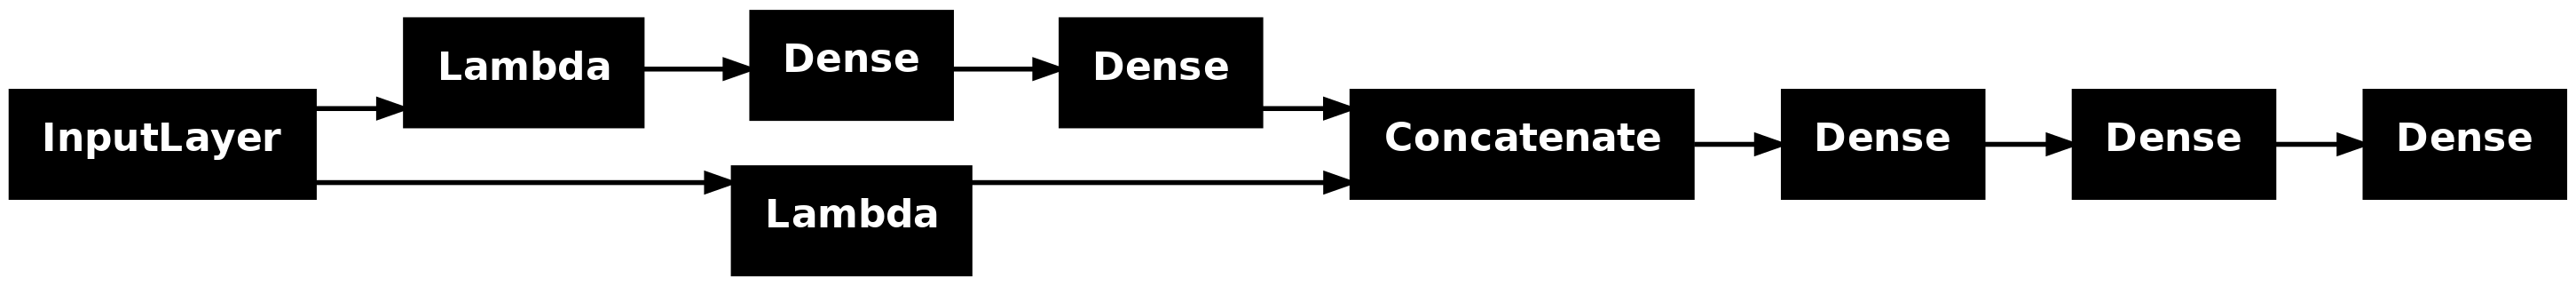

time: 81.6 ms (started: 2024-04-25 22:22:48 +03:00)


In [3]:
from tensorflow.keras.utils import plot_model
plot_model(nn_model.model, rankdir='LR')

# Summary

<function matplotlib.pyplot.show(close=None, block=None)>

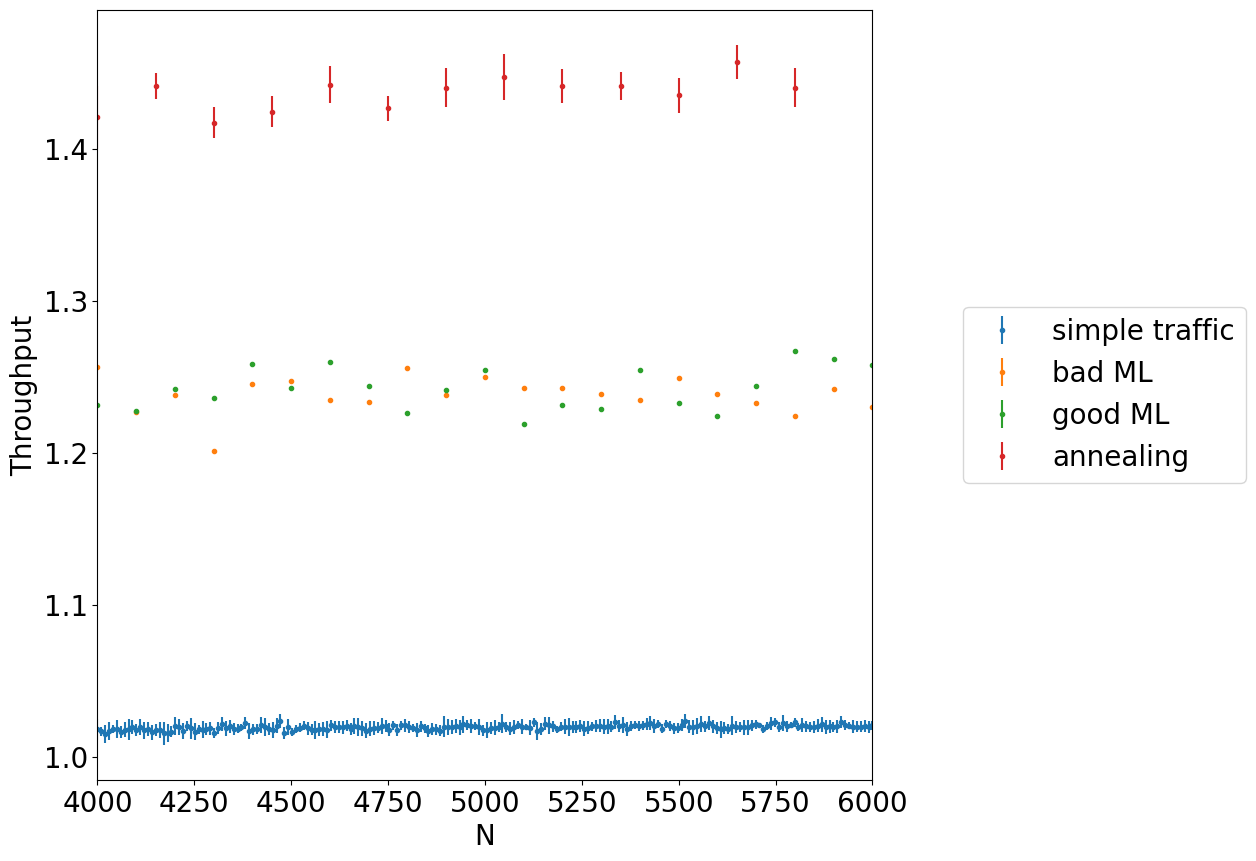

time: 91.6 ms (started: 2024-04-25 23:31:52 +03:00)


In [59]:
data = np.load('res_data/simple_throughput.npz')
bad_data_filename = 'csv_data/test6.csv'
bad_res_filename = 'res_data/learn_data/bad_ML.npz'

good_data_filename = 'csv_data/test6_cleaned.csv'
good_res_filename = 'res_data/learn_data/good_ML.npz'

fig, ax = plt.subplots()
plt.xlim([4000, 6000])
plt.rcParams["figure.figsize"] = (10, 10)
ax.set_xlabel("N")
ax.set_ylabel("Throughput")

ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label="simple traffic")
ax.errorbar(bad_data['N_arr'], bad_data['out'][:, 0], yerr=np.asarray(0*bad_data['out'][:, 1]), linestyle="", marker=".", label='bad ML')
ax.errorbar(good_data['N_arr'], good_data['out'][:, 0], yerr=np.asarray(0*good_data['out'][:, 1]), linestyle="", marker=".", label='good ML')

data=np.load('res_data/annealing_throughput.npz')
ax.errorbar(data['N_arr'], data['out'][:, 0], yerr=np.asarray(data['out'][:, 1]), linestyle="", marker=".", label='annealing')

plt.rcParams['font.size'] = '20'
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.show